# analyse slip velocity particle
In this notebook I analyse the slip velocity (difference fluid velocity and particle velocity) to make an estimation for the
Reynolds slip number as Irina pointed out that this Reynolds number might not be small and thus additional corrections should
be added to the drag term (TO DO: ASK FOR PAPER/MANUSCRIPT WITH CORRECTIONS)

In [25]:
# import needed packages
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import cartopy.crs as ccrs #for plotting on map
import cartopy as cart
from decimal import Decimal

from datetime import datetime, timedelta
from analysis_functions import trajectory_length,  make_PDF, Haversine, running_mean
import sys
sys.path.append("/nethome/4291387/Maxey_Riley_advection/Maxey_Riley_advection/simulations")
from helper import create_filelist

plt.style.use('../python_style_Meike.mplstyle')

Rearth = 6371 * 10**3 # in m,
deg2rad = np.pi / 180.


file_tracer = ('/storage/shared/oceanparcels/output_data/'
             'data_Meike/MR_advection/NWES/tracer/'
             'custom_start2023_09_01_end2023_10_01_RK4_anti_beaching_vorticity_False.zarr')

file_stokes = ('/storage/shared/oceanparcels/output_data/'
             'data_Meike/MR_advection/NWES/inertial/'
             'custom_start2023_09_01_end2023_10_01_RK4_B0680_tau2759_anti_beaching_cor_True_vorticity_False.zarr')

file_newton = ('/storage/shared/oceanparcels/output_data/data_Meike/'
               'MR_advection/NWES/inertial_Newton/'
               'custom_start2023_09_01_end2023_10_01_RK4_B0680_tau2759_anti_beaching_cor_True_vorticity_False.zarr')

             

In [22]:
# define functions
def Re_slip(Uslip, L, nu):
    """
    Calculates Reynolds number based 
    on slip velocity particle
    L is lengthscale particle
    Uslip slip velocity (differnece particle and fluid velocity)
    nu is kinematic velocity water
    """
    return Uslip*L / nu

# needed functions: 
def calc_tidal_av(coordinates, window):
    cs = coordinates.cumsum(dim='obs',skipna=False)
    mean = (cs-cs.roll(obs=window))/float(window)#(cs[:,window:]-cs[:,:-window])#/float(window)
    return mean

L = 0.2 #m
rho_water = 1027 # kg/m3 https://www.engineeringtoolbox.com/sea-water-properties-d_840.html (at 10 deg)
dynamic_viscosity_water = 1.41 * 10**(-3) # kg/(ms) https://www.engineeringtoolbox.com/sea-water-properties-d_840.html (at 10 deg)
kinematic_viscosity_water = dynamic_viscosity_water / rho_water

In [26]:
# import data with molecular stokes drag (no corretions)
nparticles=293914
chunck_time=100
Tend=720


# import data with molecular stokes drag
ds_stokes = xr.open_dataset(file_stokes,
                     engine='zarr',
                     chunks={'trajectory':nparticles, 'obs':chunck_time},
                     drop_variables=['B','tau','z'],
                     decode_times=False) #,decode_cf=False)

# import data with newtonian drag
ds_newton = xr.open_dataset(file_newton,
                     engine='zarr',
                     #chunks={'trajectory':nparticles, 'obs':chunck_time},
                     drop_variables=['B','tau','z'],
                     decode_times=False) #,decode_cf=False)

# import data with tracer drag
ds_tracer = xr.open_dataset(file_tracer,
                     engine='zarr',
                     #chunks={'trajectory':nparticles, 'obs':chunck_time},
                     decode_times=False) #,decode_cf=False)

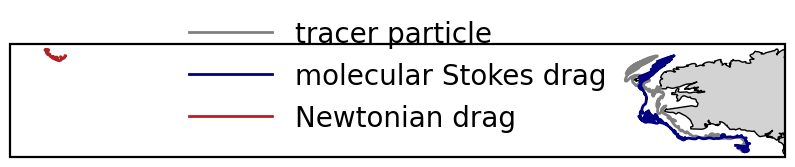

In [27]:
#compare stokes drag and newtonian drag simulation
id = 10000#np.random.randint(nparticles,size=1)[0]

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cart.feature.LAND, facecolor='lightgrey')
ax.plot(ds_tracer.lon[id].values,ds_tracer.lat[id].values,color='grey')
ax.plot(ds_stokes.lon[id].values,ds_stokes.lat[id].values,color='navy')
ax.plot(ds_newton.lon[id].values,ds_newton.lat[id].values,color='firebrick')

ax.legend(['tracer particle','molecular Stokes drag','Newtonian drag'])


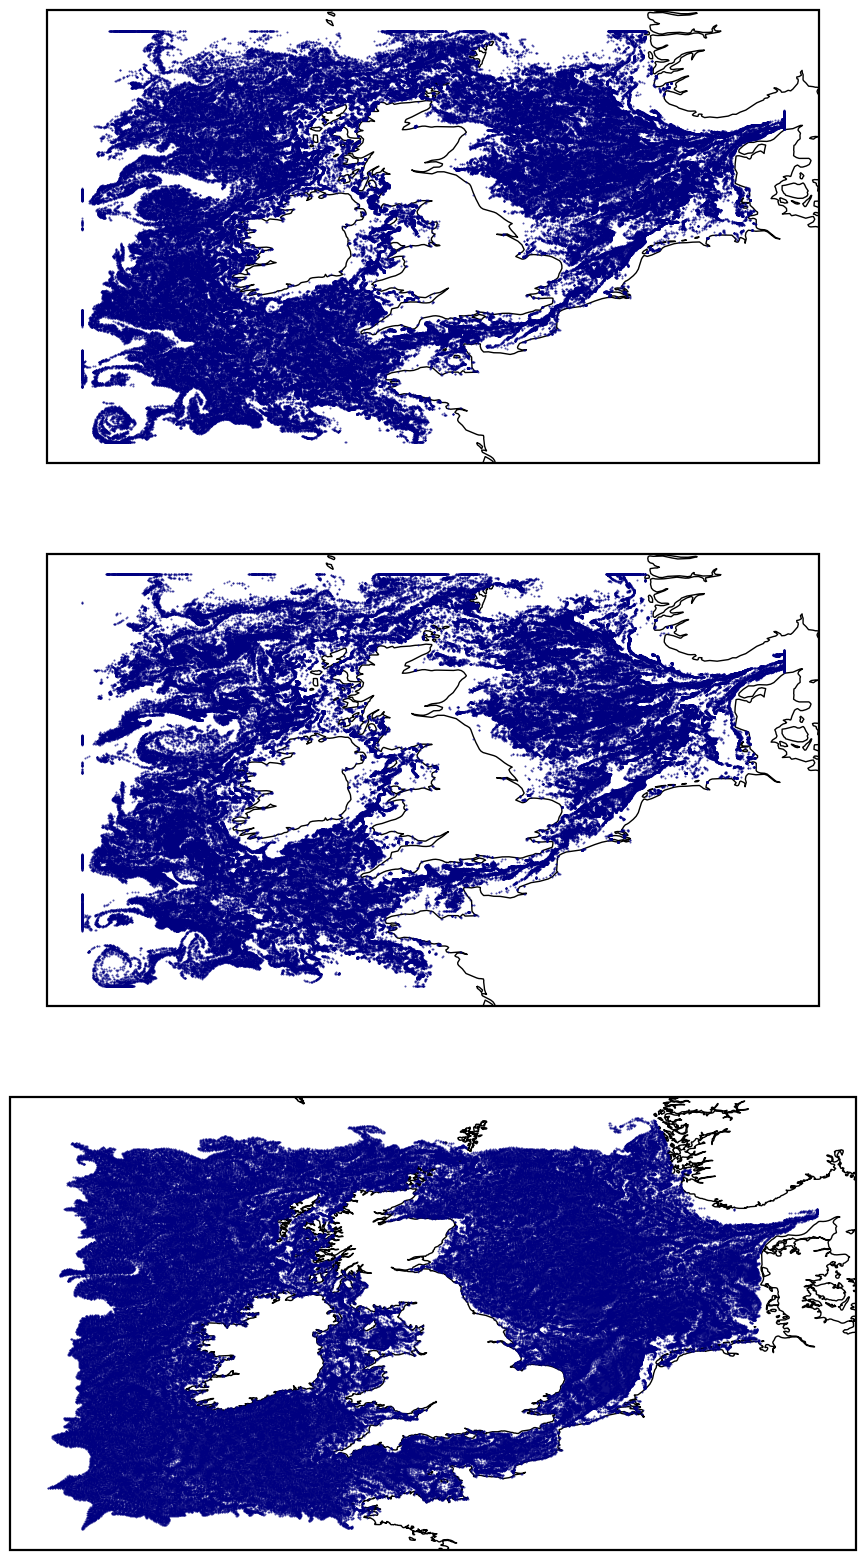

In [28]:
#final position neewtonian drag particles
fig,axs = plt.subplots(3,1,subplot_kw={'projection':ccrs.PlateCarree()},figsize=(12,20))
axs[0].plot(ds_tracer.lon.ffill(dim='obs')[:,-1].values,ds_tracer.lat.ffill(dim='obs')[:,-1].values,'.',color='navy',markersize=2,alpha=0.5)
axs[2].plot(ds_newton.lon.ffill(dim='obs')[:,-1].values,ds_newton.lat.ffill(dim='obs')[:,-1].values,'.',color='navy',markersize=2,alpha=0.5)
axs[1].plot(ds_stokes.lon.ffill(dim='obs')[:,-1].values,ds_stokes.lat.ffill(dim='obs')[:,-1].values,'.',color='navy',markersize=2,alpha=0.5)
for ax in axs:
    ax.coastlines()

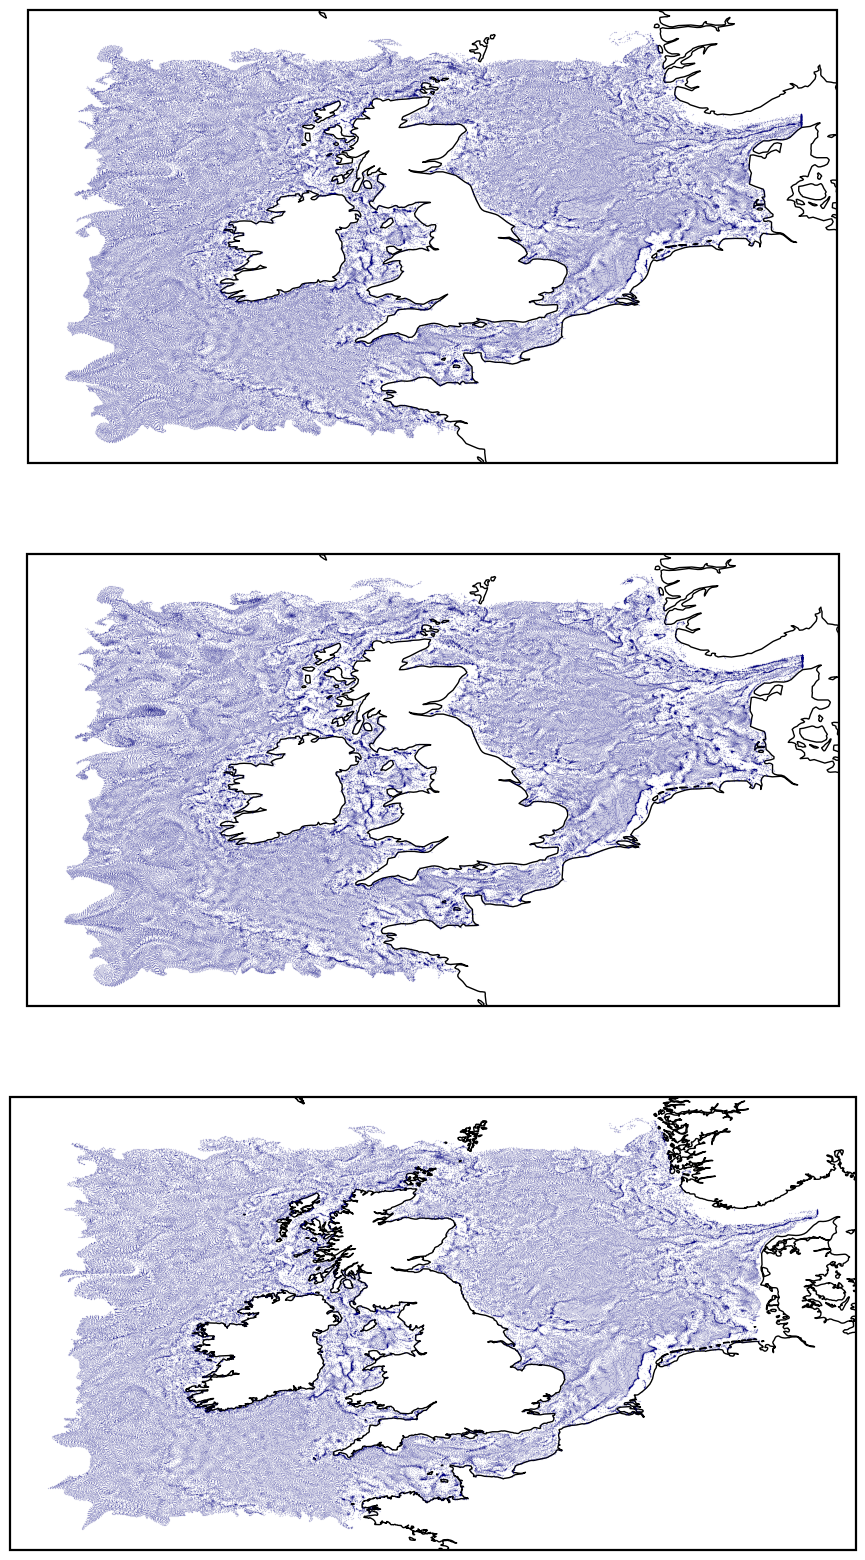

In [12]:
#final position newtonian drag particles
fig,axs = plt.subplots(3,1,subplot_kw={'projection':ccrs.PlateCarree()},figsize=(12,20))
axs[0].plot(ds_tracer.lon.ffill(dim='obs')[:,107].values,ds_tracer.lat.ffill(dim='obs')[:,107].values,'.',color='navy',markersize=1,alpha=0.1)
axs[1].plot(ds_stokes.lon.ffill(dim='obs')[:,107].values,ds_stokes.lat.ffill(dim='obs')[:,107].values,'.',color='navy',markersize=1,alpha=0.1)
axs[2].plot(ds_newton.lon.ffill(dim='obs')[:,107].values,ds_newton.lat.ffill(dim='obs')[:,107].values,'.',color='navy',markersize=1,alpha=0.1)


for ax in axs:
    ax.coastlines()

mean = 0.01808069590199836, 0.021547523735424203
mean tidal av = 0.004423657578426683, 0.008824915861913751
std = 0.029954880073638227, 0.03335574097723826
10000


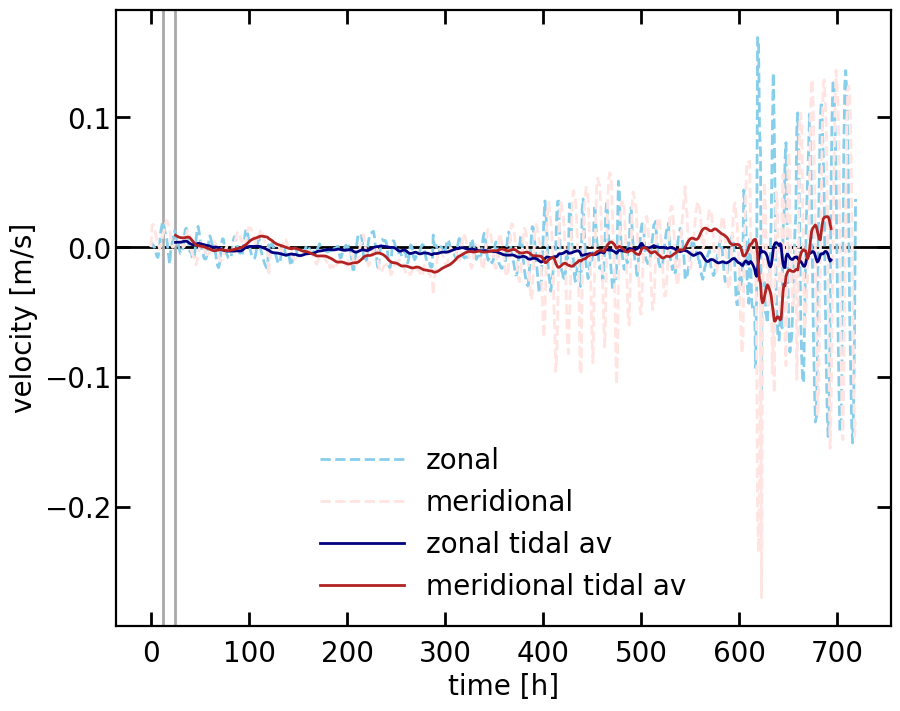

In [29]:
# stokes drag analysis
# from degrees/second to m/s 
up_min_uf = ds_stokes.uf * 2 * np.pi / 360 * Rearth * np.sin(ds_stokes.lat*np.pi/180) 
vp_min_vf = ds_stokes.vf * 2 * np.pi / 360 * Rearth
Uslip = np.sqrt(up_min_uf**2 + vp_min_vf**2)

window = 25
ttides=np.arange(window,Tend-window,1)
up_min_uf_tidal_av  = calc_tidal_av(up_min_uf,window)[:,window:Tend-25]
vp_min_vf_tidal_av  = calc_tidal_av(vp_min_vf,25)[:,window:Tend-25]

mean_udif = np.abs(up_min_uf).mean(dim=None, skipna=True).values
mean_vdif = np.abs(vp_min_vf).mean(dim=None, skipna=True).values
std_udif = up_min_uf.std(dim=None, skipna=True).values
std_vdif = vp_min_vf.std(dim=None, skipna=True).values

mean_udif_tidal_av = np.abs(up_min_uf_tidal_av).mean(dim=None, skipna=True).values
mean_vdif_tidal_av = np.abs(vp_min_vf_tidal_av).mean(dim=None, skipna=True).values

print(f'mean = {mean_udif}, {mean_vdif}')
print(f'mean tidal av = {mean_udif_tidal_av}, {mean_vdif_tidal_av}')

print(f'std = {std_udif}, {std_vdif}')
id=10000#np.random.randint(nparticles,size=1)[0]
print(id)
fig, ax=plt.subplots()
ax.plot(up_min_uf[id].values,'--',color='skyblue')
ax.plot(vp_min_vf[id].values,'--',color='mistyrose')
ax.plot(ttides,up_min_uf_tidal_av[id].values,'-',color='navy')
ax.plot(ttides,vp_min_vf_tidal_av[id].values,'-',color='firebrick')

# show tital period (and show that is is main source of oscilations)
ax.axvline(12.4,color='darkgrey',zorder=-5)
ax.axvline(24.8,color='darkgrey',zorder=-5)
ax.axhline(0,color='k',zorder=-10)
ax.set_xlabel('time [h]')
ax.set_ylabel('velocity [m/s]')
ax.legend(['zonal','meridional','zonal tidal av','meridional tidal av'])


In [30]:
# make CDF for reynoldsnumber
L = 0.2 #m
rho_water = 1027 # kg/m3 https://www.engineeringtoolbox.com/sea-water-properties-d_840.html (at 10 deg)
dynamic_viscosity_water = 1.41 * 10**(-3) # kg/(ms) https://www.engineeringtoolbox.com/sea-water-properties-d_840.html (at 10 deg)
kinematic_viscosity_water = dynamic_viscosity_water / rho_water

Re_particle = Re_slip(Uslip,L, kinematic_viscosity_water)
array = Re_particle.values.flatten()
array = array[~np.isnan(array)]
bins,pdf=make_PDF(array,nbins = 5000, norm = True)
dx=bins[1]-bins[0]
cdf = np.cumsum(pdf*dx)

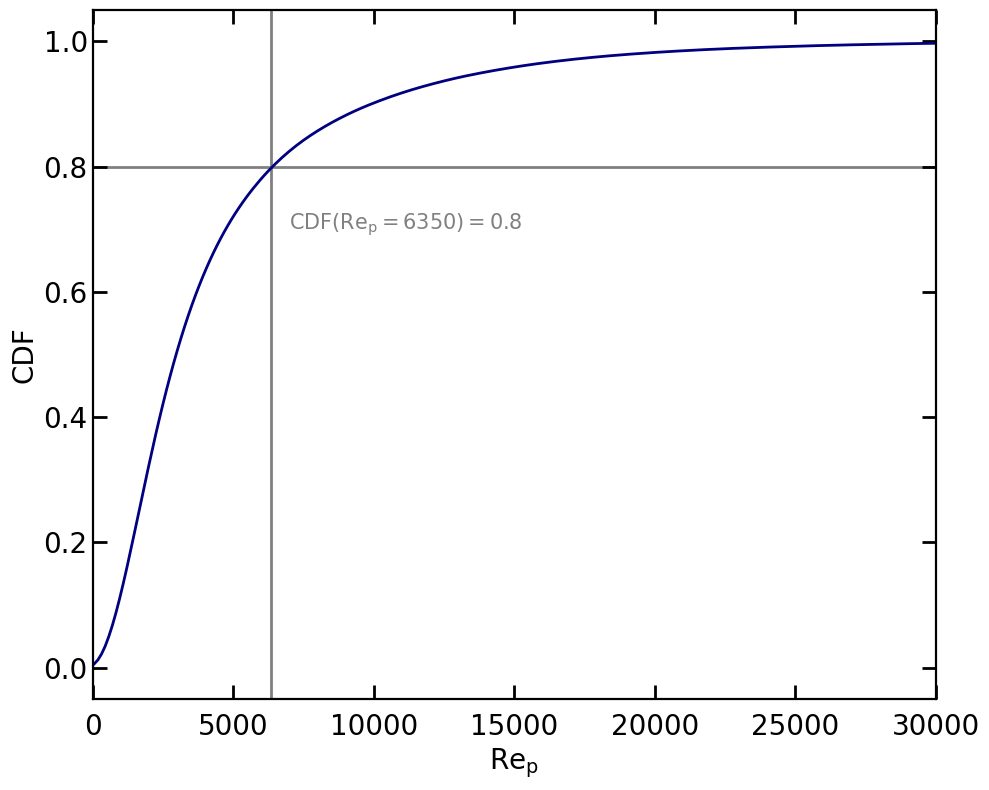

In [47]:
fig, ax = plt.subplots()
ax.plot(bins,cdf,color='navy')
ax.axhline(0.8,color='grey',zorder=-10)
ax.axvline(6350,color='grey',zorder=-10)
ax.set_xlim(0,30000)
ax.set_xlabel('$\\mathrm{Re}_{\\mathrm{p}}$')
ax.set_ylabel('CDF')
ax.text(7000,0.7,'$\\mathrm{CDF}(\\mathrm{Re}_{\\mathrm{p}}=6350)=0.8$',color='grey',fontsize=15)
fig.tight_layout()
fig.savefig('../figures/drag_force/CDF_REp_stokes_drag_1month.pdf')


(-0.1, 0.1)

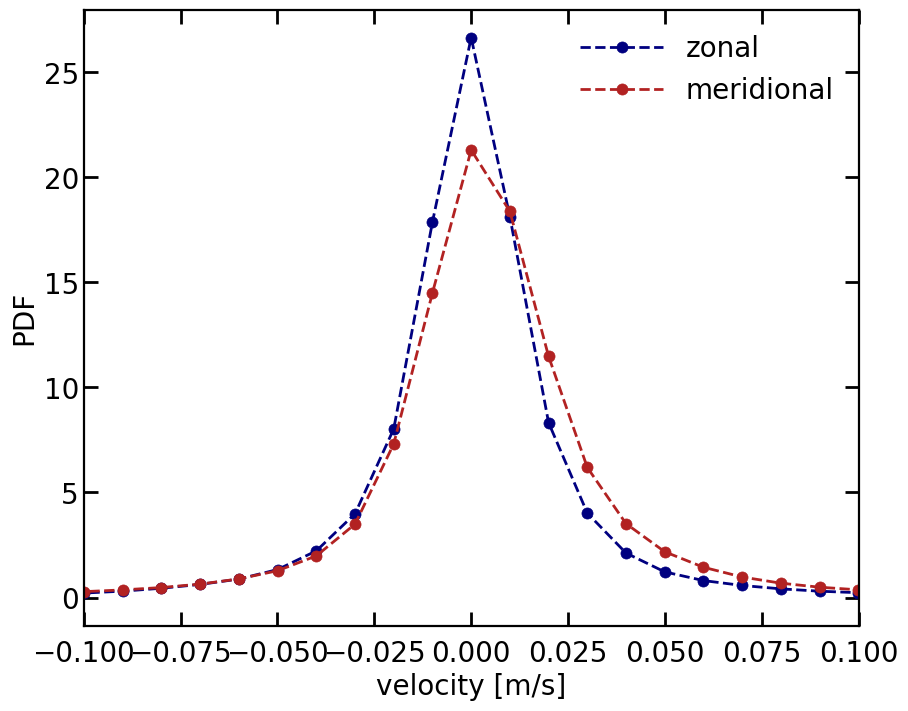

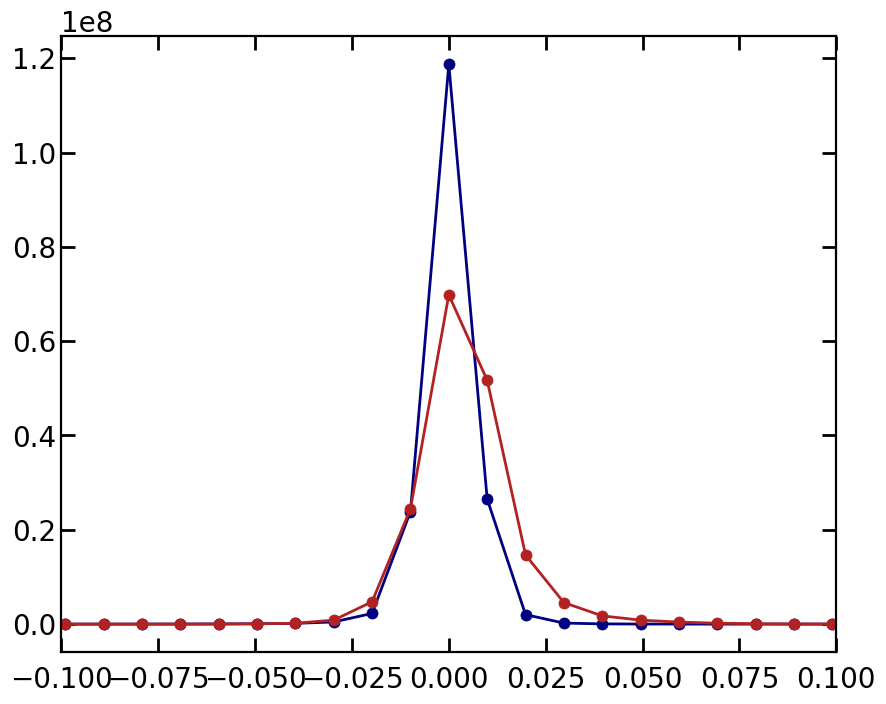

In [15]:
# make pdf (shows that most is zero and some of it is bigger thus what does this mean for "correct slip velocity?")
fig, ax = plt.subplots()

array_u = up_min_uf.values.flatten()
array_u = array_u[~np.isnan(ds.lon.values.flatten())]

bin_u, pdf_u = make_PDF(array_u,1001,True,min=-5,max=5)

array_v = vp_min_vf.values.flatten()
array_v = array_v[~np.isnan(array_v)]
bin_v, pdf_v = make_PDF(array_v,1001,True,min=-5,max=5)

ax.plot(bin_u,pdf_u,'--o',color='navy')
ax.plot(bin_v,pdf_v,'--o',color='firebrick')
ax.set_xlim(-0.1,0.1)
array_u_tidal_av = up_min_uf_tidal_av.values.flatten()
array_u_tidal_av = array_u_tidal_av[~np.isnan(array_u_tidal_av)]
bin_u_tidal_av, pdf_u_tidal_av = make_PDF(array_u_tidal_av,101,False,min=-0.5 ,max=0.5)

array_v_tidal_av = vp_min_vf_tidal_av.values.flatten()
array_v_tidal_av = array_v_tidal_av[~np.isnan(array_v_tidal_av)]
bin_v_tidal_av, pdf_v_tidal_av = make_PDF(array_v_tidal_av,101,False, min=-0.5,max=0.5)
ax.set_xlabel('velocity [m/s]')
ax.set_ylabel('PDF')
ax.legend(['zonal','meridional'])
fig2,ax2=plt.subplots()

ax2.plot(bin_u_tidal_av,pdf_u_tidal_av,'-o',color='navy')
ax2.plot(bin_v_tidal_av,pdf_v_tidal_av,'-o',color='firebrick')
ax2.set_xlim(-0.1,0.1)

In [16]:
# calculate Reynoldsnumber

Re_slip_u =Re_slip(mean_vdif,L,kinematic_viscosity_water)
Re_slip_v =Re_slip(mean_vdif_tidal_av,L,kinematic_viscosity_water)
print(f'Re_slip_u = { Re_slip_u}')
print(f'Re_slip_u = { Re_slip_v}')

Re_slip_u = 3138.908776777398
Re_slip_u = 1285.558665274528


In [15]:
# test slip velocity dependence on different timesteps
file_dt5min = '/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/inertial/custom_start2023_09_01_end2023_09_01_RK4_B0680_tau2759_anti_beaching_cor_True_vorticity_False_dt_5min.zarr'
file_dt1min = '/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/inertial/custom_start2023_09_01_end2023_09_01_RK4_B0680_tau2759_anti_beaching_cor_True_vorticity_False_dt_1min.zarr'
file_dt10sec = '/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/inertial/custom_start2023_09_01_end2023_09_01_RK4_B0680_tau2759_anti_beaching_cor_True_vorticity_False_dt_10sec.zarr'


ds_dt5min = xr.open_dataset(file_dt5min,
                     engine='zarr',
                     #chunks={'trajectory':nparticles, 'obs':chunck_time},
                     drop_variables=['B','tau','z'],
                     decode_times=False) #,decode_cf=False)
ds_dt1min = xr.open_dataset(file_dt1min,
                     engine='zarr',
                     #chunks={'trajectory':nparticles, 'obs':chunck_time},
                     drop_variables=['B','tau','z'],
                     decode_times=False) #,decode_cf=False)
ds_dt10sec = xr.open_dataset(file_dt10sec,
                     engine='zarr',
                     #chunks={'trajectory':nparticles, 'obs':chunck_time},
                     drop_variables=['B','tau','z'],
                     decode_times=False) #,decode_cf=False)

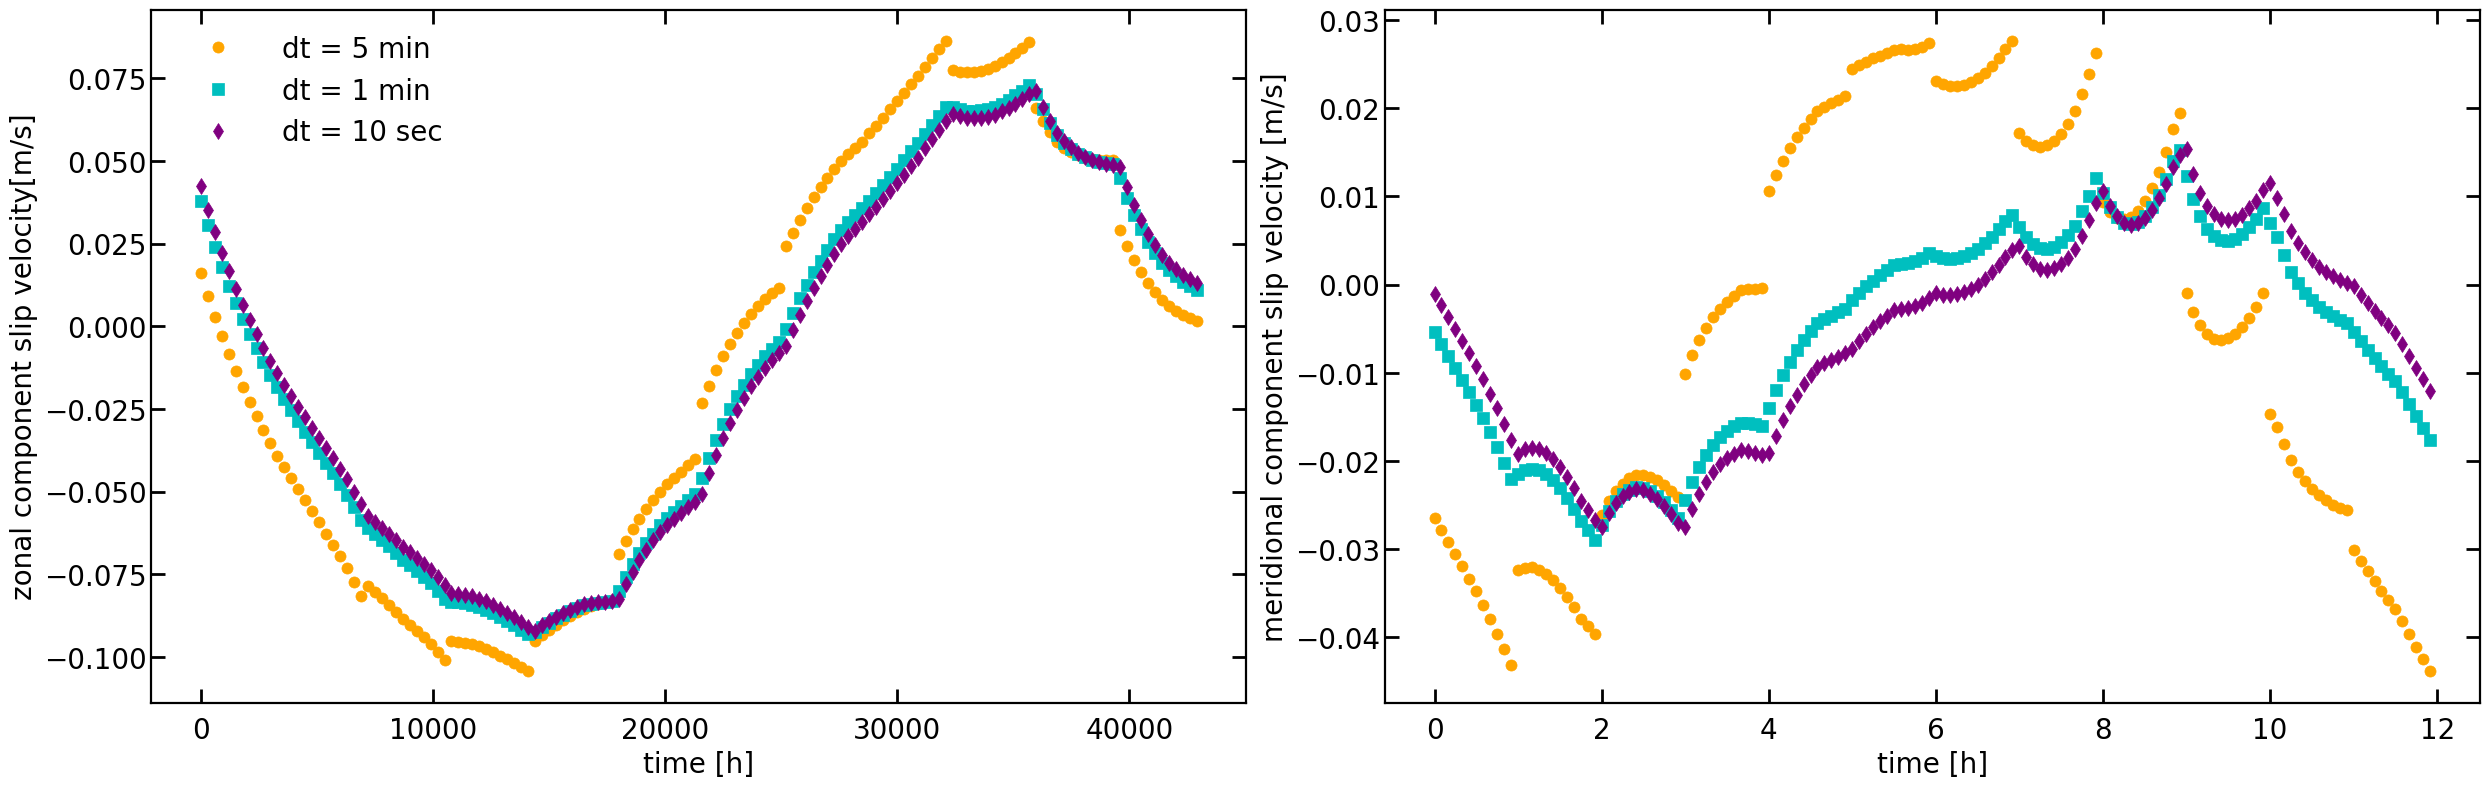

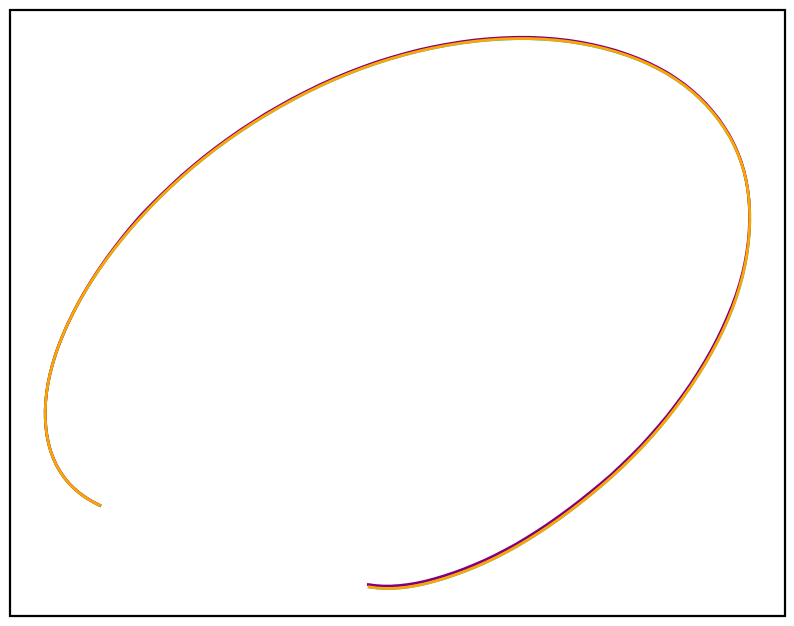

In [46]:
id = 5745
sec_in_hour=3600
fig, axs = plt.subplots(1,2, figsize=(25,8))
axs[0].plot(ds_dt5min.time[id],ds_dt5min.uf[id]- (ds_dt5min.up[id] * 2 * np.pi / 360 * Rearth * np.sin(ds_dt5min.lat[id]*np.pi/180)),'o',color='orange' )
axs[0].plot(ds_dt1min.time[id,],ds_dt1min.uf[id]- (ds_dt1min.up[id] * 2 * np.pi / 360 * Rearth * np.sin(ds_dt1min.lat[id]*np.pi/180)),'s',color='c' )
axs[0].plot(ds_dt10sec.time[id],ds_dt10sec.uf[id] - (ds_dt10sec.up[id] * 2 * np.pi / 360 * Rearth * np.sin(ds_dt10sec.lat[id]*np.pi/180)),'d',color='purple' )
axs[0].set_xlabel('time [h]')
axs[0].set_ylabel('zonal component slip velocity[m/s]')
axs[0].legend(['dt = 5 min','dt = 1 min', 'dt = 10 sec'])
axs[1].plot(ds_dt5min.time[id]/sec_in_hour,ds_dt5min.vf[id]- (ds_dt5min.vp[id] * 2 * np.pi / 360 * Rearth ) ,'o',color='orange' )
axs[1].plot(ds_dt1min.time[id,]/sec_in_hour,ds_dt1min.vf[id]- (ds_dt1min.vp[id] * 2 * np.pi / 360 * Rearth ),'s',color='c' )
axs[1].plot(ds_dt10sec.time[id]/sec_in_hour,ds_dt10sec.vf[id] - (ds_dt10sec.vp[id] * 2 * np.pi / 360 * Rearth ),'d',color='purple' )
axs[1].set_xlabel('time [h]')
axs[1].set_ylabel('meridional component slip velocity [m/s]')


fig2,ax2 = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ax2.coastlines()
ax2.add_feature(cart.feature.LAND, facecolor='lightgrey')
ax2.plot(ds_dt5min.lon[id],ds_dt5min.lat[id],color='orange',zorder=10)
ax2.plot(ds_dt1min.lon[id],ds_dt1min.lat[id],color='c')
ax2.plot(ds_dt10sec.lon[id],ds_dt10sec.lat[id],color='purple')

fig.tight_layout()
fig.savefig(f'../figures/drag_force/slip_velocity_particle{id}_12h_dt_10s_1m_5m.pdf')


In [23]:
#make pdfs for slip velocity

up_min_uf =ds_dt5min.uf- (ds_dt5min.up * 2 * np.pi / 360 * Rearth * np.sin(ds_dt5min.lat*np.pi/180))
vp_min_vf =ds_dt5min.vf- (ds_dt5min.vp * 2 * np.pi / 360 * Rearth)
Uslip_dt5min = np.sqrt(up_min_uf**2 + vp_min_vf**2)
Re_particle_dt5min = Re_slip(Uslip = Uslip_dt5min,L=L, nu = kinematic_viscosity_water)
array_dt5min = Re_particle_dt5min.values.flatten()
array_dt5min = array_dt5min[~np.isnan(array_dt5min)]
bins_dt5min, pdf_dt5min = make_PDF(array_dt5min,nbins=5000, norm=True)
dx_dt5min = bins_dt5min[1]-bins_dt5min[0]
cdf_dt5min = np.cumsum(pdf_dt5min*dx_dt5min)

up_min_uf =ds_dt1min.uf- (ds_dt1min.up * 2 * np.pi / 360 * Rearth * np.sin(ds_dt1min.lat*np.pi/180))
vp_min_vf =ds_dt1min.vf- (ds_dt1min.vp * 2 * np.pi / 360 * Rearth)
Uslip_dt1min = np.sqrt(up_min_uf**2 + vp_min_vf**2)
Re_particle_dt1min = Re_slip(Uslip = Uslip_dt1min,L=L, nu = kinematic_viscosity_water)
array_dt1min = Re_particle_dt1min.values.flatten()
array_dt1min = array_dt1min[~np.isnan(array_dt1min)]
bins_dt1min, pdf_dt1min = make_PDF(array_dt1min,nbins=5000, norm=True)
dx_dt1min = bins_dt1min[1]-bins_dt1min[0]
cdf_dt1min = np.cumsum(pdf_dt1min*dx_dt1min)

up_min_uf =ds_dt10sec.uf- (ds_dt10sec.up * 2 * np.pi / 360 * Rearth * np.sin(ds_dt10sec.lat*np.pi/180))
vp_min_vf =ds_dt10sec.vf- (ds_dt10sec.vp * 2 * np.pi / 360 * Rearth)
Uslip_dt10sec = np.sqrt(up_min_uf**2 + vp_min_vf**2)
Re_particle_dt10sec = Re_slip(Uslip = Uslip_dt10sec,L=L, nu = kinematic_viscosity_water)
array_dt10sec = Re_particle_dt10sec.values.flatten()
array_dt10sec = array_dt10sec[~np.isnan(array_dt10sec)]
bins_dt10sec, pdf_dt10sec = make_PDF(array_dt10sec,nbins=5000, norm=True)
dx_dt10sec = bins_dt10sec[1]-bins_dt10sec[0]
cdf_dt10sec = np.cumsum(pdf_dt10sec*dx_dt10sec)



(0.0, 50000.0)

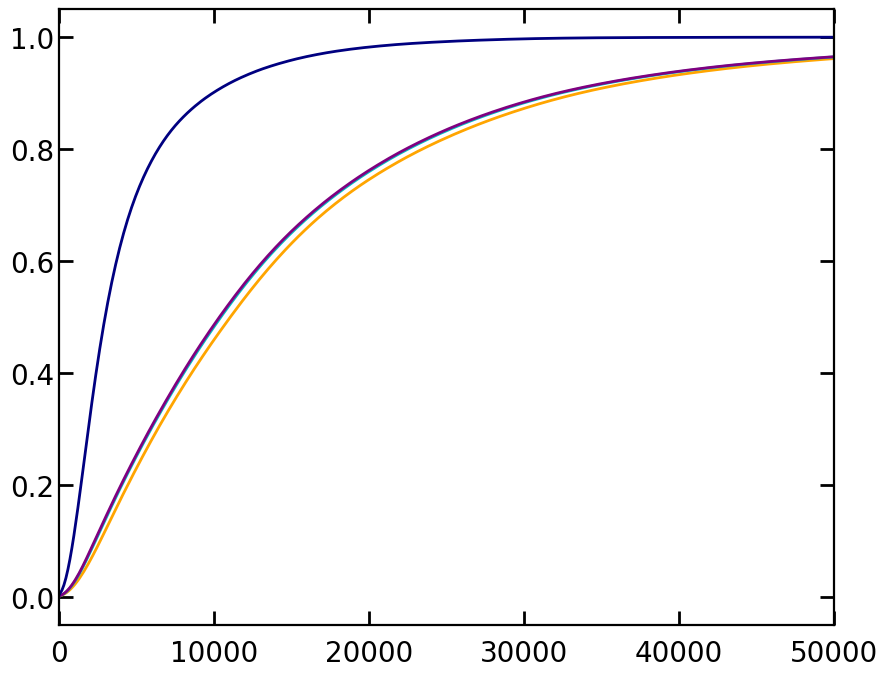

In [48]:
fig, ax= plt.subplots()
ax.plot(bins_dt5min,cdf_dt5min,color='orange')
ax.plot(bins_dt1min,cdf_dt1min,color='c')
ax.plot(bins_dt10sec,cdf_dt10sec,color='purple')
ax.plot(bins,cdf,color='navy')
ax.set_xlim(0,50000)
#clearly simulating for 12 h is not enough to get the same distribution
#therefore restart simuatlion for longer times